In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px


In [34]:
# Load the dataset
file_path = 'AAPL_stocks.csv'  # Update this with the correct file path
data = pd.read_csv(file_path)
# Parse the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
# Sort the data by date
data.sort_values('Date', inplace=True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470740,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481928,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378823,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800
...,...,...,...,...,...,...,...
3576,2024-03-20,175.720001,178.669998,175.089996,178.669998,178.669998,53423100
3577,2024-03-21,177.050003,177.490005,170.839996,171.369995,171.369995,106181300
3578,2024-03-22,171.759995,173.050003,170.059998,172.279999,172.279999,71106600
3579,2024-03-25,170.570007,171.940002,169.449997,170.850006,170.850006,54235800


# Algo based on EMA 20 50 & 100

- 1st version

In [48]:
import pandas as pd
import plotly.graph_objects as go

# Load the dataset
file_path = 'AAPL_stocks.csv'  # Update this with the correct file path
data = pd.read_csv(file_path)

# Parse the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date (if not already sorted)
data.sort_values('Date', inplace=True)

# Calculate the 20-day, 50-day, and 100-day EMAs
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_100'] = data['Close'].ewm(span=100, adjust=False).mean()

# Initialize Signal column
data['Signal'] = ''

# Define tolerance for EMA convergence (5%)
tolerance = 0.02

# Find points where all three EMAs converge (within tolerance)
data['EMAs_Converge'] = ((abs(data['EMA_20'] / data['EMA_50'] - 1) <= tolerance) &
                         (abs(data['EMA_20'] / data['EMA_100'] - 1) <= tolerance) &
                         (abs(data['EMA_50'] / data['EMA_100'] - 1) <= tolerance))

# Determine buy or sell signals
in_signal = False  # Flag to track if we're currently in a buy/sell signal
last_signal = None  # Variable to store the last generated signal

for i in range(1, len(data)-1):  # Adjusted range to accommodate checking one candle ahead and behind
    if data['EMAs_Converge'][i]:
        # Check for "Buy" condition: All EMAs are increasing after convergence
        if (data['EMA_20'][i] > data['EMA_20'][i-1]) and (data['EMA_50'][i] > data['EMA_50'][i-1]) and (data['EMA_100'][i] > data['EMA_100'][i-1]):
            data.loc[i, 'Signal'] = 'Buy'
        # Check for "Sell" condition: All EMAs are decreasing after convergence
        elif (data['EMA_20'][i] < data['EMA_20'][i-1]) and (data['EMA_50'][i] < data['EMA_50'][i-1]) and (data['EMA_100'][i] < data['EMA_100'][i-1]):
            data.loc[i, 'Signal'] = 'Sell'

# Filter data for points where signals are generated
signals = data[data['Signal'].isin(['Buy', 'Sell'])]

# Create a candlestick chart using Plotly
fig = go.Figure()

# Candlestick trace
fig.add_trace(go.Candlestick(x=data['Date'],
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'],
                             name='Candlestick',
                             yaxis='y'))  # Assign to primary y-axis

# EMAs traces
fig.add_trace(go.Scatter(x=data['Date'], y=data['EMA_20'], mode='lines', name='EMA 20', yaxis='y'))
fig.add_trace(go.Scatter(x=data['Date'], y=data['EMA_50'], mode='lines', name='EMA 50', yaxis='y'))
fig.add_trace(go.Scatter(x=data['Date'], y=data['EMA_100'], mode='lines', name='EMA 100', yaxis='y'))

# Buy and Sell signals
fig.add_trace(go.Scatter(x=signals[signals['Signal'] == 'Buy']['Date'], y=signals[signals['Signal'] == 'Buy']['Low'],
                         mode='markers', marker=dict(symbol='triangle-up', size=10, color='green'),
                         name='Buy Signal', yaxis='y'))
fig.add_trace(go.Scatter(x=signals[signals['Signal'] == 'Sell']['Date'], y=signals[signals['Signal'] == 'Sell']['High'],
                         mode='markers', marker=dict(symbol='triangle-down', size=10, color='red'),
                         name='Sell Signal', yaxis='y'))

# Update layout for better visualization
fig.update_layout(
    title='AAPL Stock Prices with Persistent Buy/Sell Signals at EMA Convergence (5% Tolerance)',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date',
        fixedrange=False  # Allows zooming on the x-axis
    ),
    yaxis=dict(
        title='Price',
        side='left',
        showgrid=True,
        zeroline=False,
        fixedrange=False  # Allows zooming on the y-axis
    ),
    yaxis2=dict(
        title='Price',
        overlaying='y',
        side='right',
        showgrid=True,
        zeroline=False
    ),
    template='plotly_dark',
    width=1400,  # Set the width of the plot
    height=800   # Set the height of the plot
)

# Show the plot
fig.show()


# Algo based on Candles (closing) and EMA (20, 50, 100)

- 1st vesrion

In [49]:
import pandas as pd
import plotly.graph_objects as go

# Load the dataset
file_path = 'AAPL_stocks.csv'  # Update this with the correct file path
data = pd.read_csv(file_path)

# Parse the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date (if not already sorted)
data.sort_values('Date', inplace=True)

# Calculate the 20-day, 50-day, and 100-day EMAs
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_100'] = data['Close'].ewm(span=100, adjust=False).mean()

# Initialize Signal column
data['Signal'] = ''

# Define tolerance for EMA convergence (5%)
tolerance = 0.02

# Find points where all three EMAs converge (within tolerance)
data['EMAs_Converge'] = ((abs(data['EMA_20'] / data['EMA_50'] - 1) <= tolerance) &
                         (abs(data['EMA_20'] / data['EMA_100'] - 1) <= tolerance) &
                         (abs(data['EMA_50'] / data['EMA_100'] - 1) <= tolerance))

# Determine buy or sell signals
in_signal = False  # Flag to track if we're currently in a buy/sell signal
last_signal = None  # Variable to store the last generated signal

for i in range(2, len(data)-2):  # Adjust range to accommodate checking two candles ahead and behind
    if data['EMAs_Converge'][i]:
        # Check for "Buy" condition: EMAs are increasing and closing prices are also increasing
        if (data['Close'][i-2] < data['Close'][i-1] < data['Close'][i]) and (data['EMA_20'][i-1] > data['EMA_20'][i-2]) and (data['EMA_50'][i-1] > data['EMA_50'][i-2]) and (data['EMA_100'][i-1] > data['EMA_100'][i-2]):
            data.loc[i, 'Signal'] = 'Buy'
            in_signal = True
            last_signal = 'Buy'
        # Check for "Sell" condition: EMAs are decreasing and closing prices are also decreasing
        elif (data['Close'][i-2] > data['Close'][i-1] > data['Close'][i]) and (data['EMA_20'][i-1] < data['EMA_20'][i-2]) and (data['EMA_50'][i-1] < data['EMA_50'][i-2]) and (data['EMA_100'][i-1] < data['EMA_100'][i-2]):
            data.loc[i, 'Signal'] = 'Sell'
            in_signal = True
            last_signal = 'Sell'
        else:
            if in_signal:  # Continue with the same signal until conditions change
                data.loc[i, 'Signal'] = last_signal

    else:
        in_signal = False  # Reset flag when EMAs do not converge

# Filter data for points where signals are generated
signals = data[data['Signal'].isin(['Buy', 'Sell'])]

# Create a candlestick chart using Plotly
fig = go.Figure()

# Candlestick trace
fig.add_trace(go.Candlestick(x=data['Date'],
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'],
                             name='Candlestick',
                             yaxis='y'))  # Assign to primary y-axis

# EMAs traces
fig.add_trace(go.Scatter(x=data['Date'], y=data['EMA_20'], mode='lines', name='EMA 20', yaxis='y'))
fig.add_trace(go.Scatter(x=data['Date'], y=data['EMA_50'], mode='lines', name='EMA 50', yaxis='y'))
fig.add_trace(go.Scatter(x=data['Date'], y=data['EMA_100'], mode='lines', name='EMA 100', yaxis='y'))

# Buy and Sell signals
fig.add_trace(go.Scatter(x=signals[signals['Signal'] == 'Buy']['Date'], y=signals[signals['Signal'] == 'Buy']['Low'],
                         mode='markers', marker=dict(symbol='triangle-up', size=10, color='green'),
                         name='Buy Signal', yaxis='y'))
fig.add_trace(go.Scatter(x=signals[signals['Signal'] == 'Sell']['Date'], y=signals[signals['Signal'] == 'Sell']['High'],
                         mode='markers', marker=dict(symbol='triangle-down', size=10, color='red'),
                         name='Sell Signal', yaxis='y'))

# Update layout for better visualization
fig.update_layout(
    title='AAPL Stock Prices with Persistent Buy/Sell Signals at EMA Convergence (5% Tolerance)',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date',
        fixedrange=False  # Allows zooming on the x-axis
    ),
    yaxis=dict(
        title='Price',
        side='left',
        showgrid=True,
        zeroline=False,
        fixedrange=False  # Allows zooming on the y-axis
    ),
    yaxis2=dict(
        title='Price',
        overlaying='y',
        side='right',
        showgrid=True,
        zeroline=False
    ),
    template='plotly_dark',
    width=1400,  # Set the width of the plot
    height=800   # Set the height of the plot
)

# Show the plot
fig.show()


 -2nd version 

In [57]:
import pandas as pd
import plotly.graph_objects as go

# Load the dataset
file_path = 'AAPL_stocks.csv'  # Update this with the correct file path
data = pd.read_csv(file_path)

# Parse the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date (if not already sorted)
data.sort_values('Date', inplace=True)

# Calculate the 20-day, 50-day, and 100-day EMAs
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_100'] = data['Close'].ewm(span=100, adjust=False).mean()

# Initialize Signal column
data['Signal'] = ''

# Define tolerance for EMA convergence (5%)
tolerance = 0.02

# Find points where all three EMAs converge (within tolerance)
data['EMAs_Converge'] = ((abs(data['EMA_20'] / data['EMA_50'] - 1) <= tolerance) &
                         (abs(data['EMA_20'] / data['EMA_100'] - 1) <= tolerance) &
                         (abs(data['EMA_50'] / data['EMA_100'] - 1) <= tolerance))

# Determine buy or sell signals
in_signal = False  # Flag to track if we're currently in a buy/sell signal
last_signal = None  # Variable to store the last generated signal

for i in range(2, len(data)-2):  # Adjust range to accommodate checking two candles ahead and behind
    if data['EMAs_Converge'][i]:
        # Check for "Buy" condition: EMAs are increasing and closing prices are also increasing
        if (data['Close'][i-2] < data['Close'][i-1] < data['Close'][i]) and (data['EMA_20'][i-1] > data['EMA_20'][i-2]) and (data['EMA_50'][i-1] > data['EMA_50'][i-2]) and (data['EMA_100'][i-1] > data['EMA_100'][i-2]):
            data.loc[i, 'Signal'] = 'Buy'
            in_signal = True
            last_signal = 'Buy'
        # Check for "Sell" condition: EMAs are decreasing and closing prices are also decreasing
        elif (data['Close'][i-2] > data['Close'][i-1] > data['Close'][i]) and (data['EMA_20'][i-1] < data['EMA_20'][i-2]) and (data['EMA_50'][i-1] < data['EMA_50'][i-2]) and (data['EMA_100'][i-1] < data['EMA_100'][i-2]):
            data.loc[i, 'Signal'] = 'Sell'
            in_signal = True
            last_signal = 'Sell'
        else:
            if in_signal:  # Continue with the same signal until conditions change
                data.loc[i, 'Signal'] = last_signal

    else:
        in_signal = False  # Reset flag when EMAs do not converge

# Filter data for points where signals are generated
signals = data[data['Signal'].isin(['Buy', 'Sell'])]

# Initialize columns for profit percentage
signals['Profit %'] = 0.0

# Calculate profit percentages
for i in range(len(signals)-1):
    if signals['Signal'].iloc[i] == 'Buy':
        buy_price = signals['Close'].iloc[i+1]  # Buy at the next day's closing price
        sell_price = signals['Close'].iloc[i]   # Sell at the current day's closing price
        profit_percent = ((sell_price - buy_price) / buy_price) * 100
        signals['Profit %'].iloc[i] = profit_percent

# Create a candlestick chart using Plotly
fig = go.Figure()

# Candlestick trace
fig.add_trace(go.Candlestick(x=data['Date'],
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'],
                             name='Candlestick',
                             yaxis='y'))  # Assign to primary y-axis

# EMAs traces
fig.add_trace(go.Scatter(x=data['Date'], y=data['EMA_20'], mode='lines', name='EMA 20', yaxis='y'))
fig.add_trace(go.Scatter(x=data['Date'], y=data['EMA_50'], mode='lines', name='EMA 50', yaxis='y'))
fig.add_trace(go.Scatter(x=data['Date'], y=data['EMA_100'], mode='lines', name='EMA 100', yaxis='y'))

# Buy and Sell signals
fig.add_trace(go.Scatter(x=signals[signals['Signal'] == 'Buy']['Date'], y=signals[signals['Signal'] == 'Buy']['Low'],
                         mode='markers', marker=dict(symbol='triangle-up', size=10, color='green'),
                         name='Buy Signal', yaxis='y'))
fig.add_trace(go.Scatter(x=signals[signals['Signal'] == 'Sell']['Date'], y=signals[signals['Signal'] == 'Sell']['High'],
                         mode='markers', marker=dict(symbol='triangle-down', size=10, color='red'),
                         name='Sell Signal', yaxis='y'))

# Update layout for better visualization
fig.update_layout(
    title='AAPL Stock Prices with Persistent Buy/Sell Signals at EMA Convergence (5% Tolerance)',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date',
        fixedrange=False  # Allows zooming on the x-axis
    ),
    yaxis=dict(
        title='Price',
        side='left',
        showgrid=True,
        zeroline=False,
        fixedrange=False  # Allows zooming on the y-axis
    ),
    yaxis2=dict(
        title='Price',
        overlaying='y',
        side='right',
        showgrid=True,
        zeroline=False
    ),
    template='plotly_dark',
    width=1400,  # Set the width of the plot
    height=800   # Set the height of the plot
)

# Show the plot
fig.show()

# Print the signals DataFrame with profit percentages
print(signals[['Date', 'Signal', 'Profit %']])


/var/folders/hr/rf0dchj10b12tqdvgfmnxw_h0000gp/T/ipykernel_14325/981416601.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/hr/rf0dchj10b12tqdvgfmnxw_h0000gp/T/ipykernel_14325/981416601.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           Date Signal  Profit %
3    2010-01-07   Sell       0.0
4    2010-01-08   Sell       0.0
5    2010-01-11   Sell       0.0
6    2010-01-12   Sell       0.0
7    2010-01-13   Sell       0.0
...         ...    ...       ...
3561 2024-02-28   Sell       0.0
3562 2024-02-29   Sell       0.0
3563 2024-03-01   Sell       0.0
3564 2024-03-04   Sell       0.0
3565 2024-03-05   Sell       0.0

[443 rows x 3 columns]


<AxesSubplot: ylabel='Profit %'>

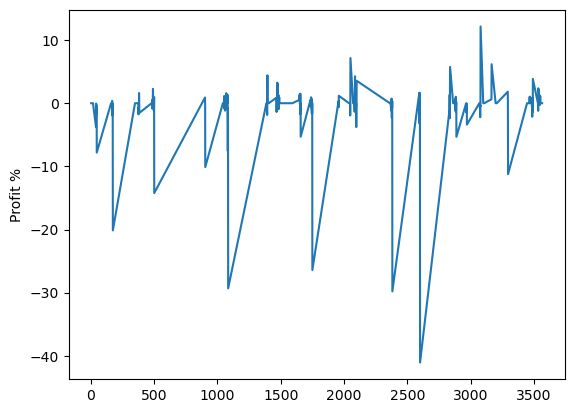

In [53]:
sns.lineplot(signals['Profit %'])

In [63]:
# Convert DataFrame to HTML with styling
html = signals.to_html(max_rows=500)

# Display the HTML content
from IPython.core.display import HTML
display(HTML(html))


,Date,Open,High,Low,Close,Adj Close,Volume,EMA_20,EMA_50,EMA_100,Signal,EMAs_Converge,Profit %
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200,7.623222,7.634798,7.638933,Sell,True,0.000000
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800,7.618222,7.632285,7.637582,Sell,True,0.000000
5,2010-01-11,7.600000,7.607143,7.444643,7.503929,6.352824,462229600,7.607337,7.627251,7.634935,Sell,True,0.000000
6,2010-01-12,7.471071,7.491786,7.372143,7.418571,6.280559,594459600,7.589359,7.619068,7.630651,Sell,True,0.000000
7,2010-01-13,7.423929,7.533214,7.289286,7.523214,6.369148,605892000,7.583059,7.615309,7.628523,Sell,True,0.000000
8,2010-01-14,7.503929,7.516429,7.465000,7.479643,6.332262,432894000,7.573210,7.609989,7.625575,Sell,True,0.000000
9,2010-01-15,7.533214,7.557143,7.352500,7.354643,6.226437,594067600,7.552394,7.599975,7.620210,Sell,True,0.000000
10,2010-01-19,7.440357,7.685357,7.401429,7.680000,6.501885,730007600,7.564547,7.603113,7.621394,Sell,True,0.000000
11,2010-01-20,7.675357,7.698214,7.482143,7.561786,6.401805,612152800,7.564284,7.601493,7.620214,Sell,True,0.000000
12,2010-01-21,7.574286,7.618214,7.400357,7.431071,6.291142,608154400,7.551597,7.594809,7.616468,Sell,True,0.000000
